### Import PCA

In [7]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.decomposition import PCA, SparsePCA
from sklearn.covariance import empirical_covariance

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

import seaborn as sns
import joblib
import os

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning) # setting ignore as a parameter and further adding category

In [8]:
rng = 42

In [9]:
p = '../data/'
input_name = 'cleaned.csv'

df = pd.read_csv(f'{p}{input_name}')

In [10]:
# set up folder to save results
#os.makedirs('export_run5_PCA')
prefix = 'export_run5_PCA/export'

In [11]:
def df_filtering(df, i_e = 'I', f_cols = []):

    filtered_df = df[df.i_e == i_e]
    filtered_df = filtered_df[f_cols+['act']]
    
    return filtered_df

def data_split(df):
    X, y = df.iloc[:,:-1], df.iloc[:,-1:]
    y = np.where(y['act']=='R',1,0)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng, stratify=y) 
    
    return X_train, X_test, y_train, y_test

In [12]:
non_feature_cols = ['control_number', 'disp_date', 'i_e', 'ship_date', 
                    'disp_date_yyyy', 'disp_date_mm', 'disp_ship_date']

target = ['act', 'dp_cd']

feature_cols = ['species_code', 'wildlf_desc', 'specific_generic_name', 'genus', 'species', 'wildlf_cat', 
                'ctry_org', 'ctry_ie','purp', 'src', 'trans_mode', 'pt_cd',
                 'qty', 'unit', #'cartons',
                 'value', 'ship_date_mm']

import_df = df_filtering(df, i_e = 'I', f_cols = feature_cols)
X_train, X_test, y_train, y_test = data_split(import_df)

In [13]:
len(import_df.columns)

17

In [14]:
X_train.head()

,species_code,wildlf_desc,specific_generic_name,genus,species,wildlf_cat,ctry_org,ctry_ie,purp,src,trans_mode,pt_cd,qty,unit,value,ship_date_mm
164498,PMIL,LIV,MILES' FIREFISH,PTEROIS,MILES,FSH,LK,LK,T,W,A,AT,2.0,NO,7.0,5
1372862,OCTV,LIV,WHIPARM OCTOPUS,OCTOPUS,VARIABILIS,MOL,CN,KR,T,W,A,HN,22.0,NO,141.0,7
1574178,GAFA,LIV,CRYSTAL CORAL,GALAXEA,FASCICULARIS,COR,ID,ID,T,W,A,AT,5.0,NO,25.0,7
569908,KATP,MEA,SKIPJACK TUNA,KATSUWONUS,PELAMIS,FSH,VS,TH,T,W,A,AN,15.0,NO,2.0,2
43368,CRUS,LIV,"CRABS,LOBSTERS, CRUSTACEANS",NaN_genus,NaN_species,CRS,TW,TW,T,W,A,LA,6490.0,NO,3555.0,5


In [15]:
X_train.shape

(1192878, 16)

#### Option 1: TargetEncoding on Categorical and RobustScaler on Numeric Cols

In [16]:
numerical_var = ['value', 'qty', 'ship_date_mm'] # <- added ship_date_mm
categorical_var = ['species_code', 'wildlf_desc', 'specific_generic_name', 'genus', 'species', 'wildlf_cat', 
                'ctry_org', 'ctry_ie','purp', 'src', 'trans_mode', 'pt_cd', 'unit']

ct_target = make_column_transformer(
    (StandardScaler(), numerical_var), # <- changed to standard
    (TargetEncoder(), categorical_var),
    remainder='passthrough')

In [17]:
X_train_t = ct_target.fit_transform(X_train, y_train)
X_test_t = ct_target.transform(X_test)

In [18]:
X_train_t[:2]

array([[-0.02619352, -0.00842565, -0.40621566,  0.00130208,  0.00393616,
         0.00130208,  0.00075635,  0.00130208,  0.01988551,  0.00127508,
         0.00181438,  0.00993194,  0.01499162,  0.01117139,  0.0069574 ,
         0.01567492],
       [-0.02573808, -0.00842559,  0.1996085 ,  0.00264988,  0.00393616,
         0.00264988,  0.00283394,  0.00254696,  0.0107438 ,  0.01617875,
         0.0077198 ,  0.00993194,  0.01499162,  0.01117139,  0.01238219,
         0.01567492]])

#### Option 2: TargetEncoding on Categorical and RobustScaler on all

In [19]:
numerical_var = ['value', 'qty'] # <- added ship_date_mm
categorical_var = ['species_code', 'wildlf_desc', 'specific_generic_name', 'genus', 'species', 'wildlf_cat', 
                'ctry_org', 'ctry_ie','purp', 'src', 'trans_mode', 'pt_cd', 'unit', 'ship_date_mm']


ct_target = make_column_transformer(
    (TargetEncoder(), categorical_var),
    #(RobustScaler(), feature_cols),    #operation is parallelized and concatenated together
    remainder='passthrough')

pipe = Pipeline([('targetEncoding', ct_target), 
                 ('standardScaler', StandardScaler()) # <- changed to standard
                ], verbose=False)

In [20]:
X_train_t = pipe.fit_transform(X_train, y_train)
X_test_t = pipe.transform(X_test)

In [21]:
X_train_t[:2]

array([[-0.21464432, -0.37088384, -0.22635742, -0.28044219, -0.41989256,
         0.19813252, -0.36436796, -0.53134016, -0.16962527, -0.02843955,
        -0.16754869, -0.31002015, -0.05388076, -0.40621566, -0.00842565,
        -0.02619352],
       [-0.19511328, -0.37088384, -0.2058624 , -0.2428953 , -0.38497922,
        -0.31753287, -0.00468166, -0.31579673, -0.16962527, -0.02843955,
        -0.16754869, -0.13140895, -0.05388076,  0.1996085 , -0.00842559,
        -0.02573808]])

#### PCA

In [22]:
# checking out the transformed data
X_train_t_df = pd.DataFrame(X_train_t, columns=X_train.columns)
X_train_t_df.describe()

,species_code,wildlf_desc,specific_generic_name,genus,species,wildlf_cat,ctry_org,ctry_ie,purp,src,trans_mode,pt_cd,qty,unit,value,ship_date_mm
count,1.192878e+06,1.192878e+06,1.192878e+06,1.192878e+06,1.192878e+06,1.192878e+06,1.192878e+06,1.192878e+06,1.192878e+06,1.192878e+06,1.192878e+06,1.192878e+06,1.192878e+06,1.192878e+06,1.192878e+06,1.192878e+06
mean,-1.353486e-15,3.806601e-15,-5.994185e-16,1.464228e-15,1.077671e-16,7.912439e-16,-4.456394e-16,1.115096e-15,3.154055e-15,-1.359933e-15,3.956916e-15,-1.997024e-15,-5.435189e-15,9.495215e-16,-1.868977e-16,6.651928e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.335129e-01,-4.882239e-01,-2.461572e-01,-2.941111e-01,-4.564103e-01,-8.561777e-01,-3.951407e-01,-5.975635e-01,-4.311474e-01,-2.182742e-01,-3.261140e-01,-5.390923e-01,-1.262274e+00,-1.617864e+00,-8.425659e-03,-2.621732e-02
25%,-2.163840e-01,-3.708838e-01,-2.205742e-01,-2.620396e-01,-4.088485e-01,-3.175329e-01,-2.907507e-01,-3.715621e-01,-1.696253e-01,-2.018745e-01,-1.675487e-01,-3.100202e-01,-5.388076e-02,-7.091277e-01,-8.425653e-03,-2.604737e-02
50%,-1.816451e-01,-2.597751e-01,-1.783510e-01,-2.042422e-01,-3.040862e-01,-8.285904e-02,-2.529845e-01,-2.512900e-01,-1.696253e-01,-2.843955e-02,-1.675487e-01,-1.915689e-01,-5.388076e-02,-1.033036e-01,-8.425630e-03,-2.519086e-02
75%,-8.057648e-02,9.591417e-02,-8.007191e-02,1.892180e-05,4.927530e-02,1.981325e-01,-2.087890e-02,-2.985789e-02,-1.696253e-01,-2.843955e-02,-1.675487e-01,1.087169e-01,-5.388076e-02,8.054327e-01,-8.425366e-03,-1.970849e-02
max,1.425753e+01,2.932796e+01,1.496011e+01,1.777819e+01,2.758922e+01,5.078290e+01,9.682820e+00,2.556022e+01,5.267843e+00,1.338322e+01,6.927907e+00,3.238588e+01,1.563030e+01,1.714169e+00,3.214475e+02,1.049846e+03


In [23]:
pca = PCA(random_state=rng)
X_train_pca = pca.fit_transform(X_train_t)
print(X_train_t.shape, X_train_pca.shape)

(1192878, 16) (1192878, 16)


In [24]:
# updated to handle any number of components
def plot_pca(pca, f_names):
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.imshow(pca.components_, interpolation = 'none', cmap = 'plasma')
    feature_names=f_names
    plt.xticks(np.arange(-0., len(feature_names), 1) , feature_names, rotation = 90, fontsize=12)
    plt.yticks(np.arange(0., pca.n_components_, 1), ['PC'+str(i) for i in range(1, pca.n_components_+1)], fontsize = 16)
    plt.colorbar()

<AxesSubplot:>

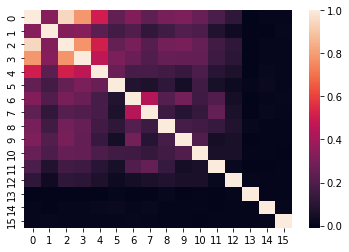

In [25]:
sns.heatmap(empirical_covariance(X_train_t))

<AxesSubplot:>

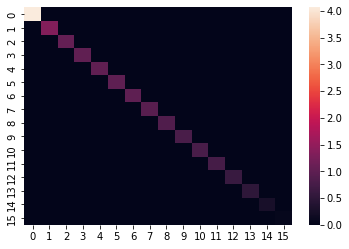

In [26]:
sns.heatmap(empirical_covariance(X_train_pca))

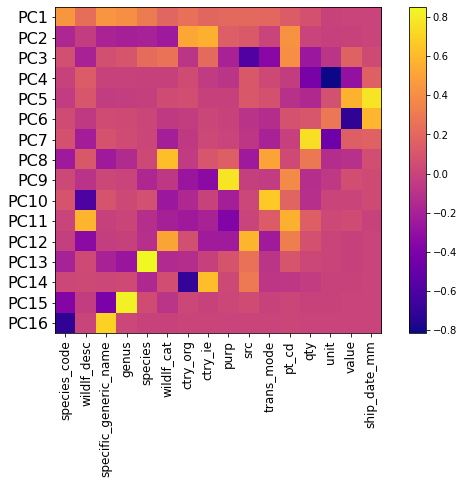

In [27]:
plot_pca(pca, feature_cols)

In [28]:
print("explained_variance_ratio:", pca.explained_variance_ratio_)
print("sum of explained variance ratios:", np.sum(pca.explained_variance_ratio_))
print("singular values:", pca.singular_values_)  

explained_variance_ratio: [0.25416502 0.08352695 0.06610683 0.06281392 0.06265103 0.06238136
 0.06194746 0.05855389 0.05347372 0.04947116 0.04934233 0.04617987
 0.03818934 0.03165603 0.01632091 0.00322019]
sum of explained variance ratios: 1.0
singular values: [2202.49987606 1262.61609298 1123.26223225 1094.92897488 1093.50833555
 1091.15240888 1087.35102951 1057.14817533 1010.24852074  971.70414291
  970.43807255  938.8243482   853.74681451  777.29565475  558.1233432
  247.91280946]


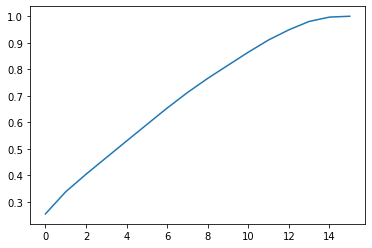

In [29]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

0     0.254165
1     0.337692
2     0.403799
3     0.466613
4     0.529264
5     0.591645
6     0.653593
7     0.712146
8     0.765620
9     0.815091
10    0.864434
11    0.910614
12    0.948803
13    0.980459
14    0.996780
15    1.000000
Name: explained var ratio, dtype: float64

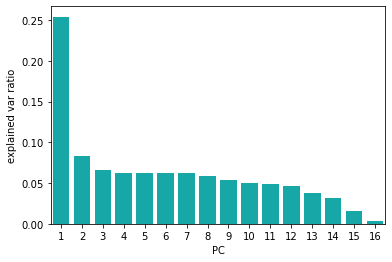

In [30]:
df = pd.DataFrame({'explained var ratio':pca.explained_variance_ratio_,
                   'PC':[str(i) for i in range(1, pca.n_components_+1)]}) # updated to handle any number of components
sns.barplot(x = 'PC',y = "explained var ratio", data = df, color="c");
np.cumsum(df['explained var ratio'])

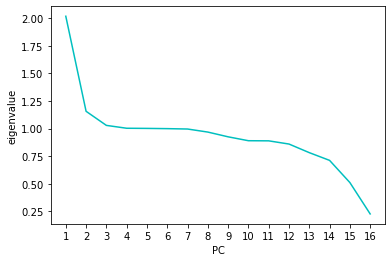

In [31]:
df = pd.DataFrame({'eigenvalue': np.sqrt(pca.explained_variance_),
                   'PC':[str(i) for i in range(1, pca.n_components_+1)]}) # updated to handle any number of components
sns.lineplot(x = 'PC',y = "eigenvalue", data = df, color="c");

#### Archive - do not run 

In [32]:
# checking out the transformed data
X_train_t_df = pd.DataFrame(X_train_t, columns=X_train.columns)
X_train_t_df.describe() 

#numerical shipment encoding

,species_code,wildlf_desc,specific_generic_name,genus,species,wildlf_cat,ctry_org,ctry_ie,purp,src,trans_mode,pt_cd,qty,unit,value,ship_date_mm
count,1.192878e+06,1.192878e+06,1.192878e+06,1.192878e+06,1.192878e+06,1.192878e+06,1.192878e+06,1.192878e+06,1.192878e+06,1.192878e+06,1.192878e+06,1.192878e+06,1.192878e+06,1.192878e+06,1.192878e+06,1.192878e+06
mean,-1.353486e-15,3.806601e-15,-5.994185e-16,1.464228e-15,1.077671e-16,7.912439e-16,-4.456394e-16,1.115096e-15,3.154055e-15,-1.359933e-15,3.956916e-15,-1.997024e-15,-5.435189e-15,9.495215e-16,-1.868977e-16,6.651928e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.335129e-01,-4.882239e-01,-2.461572e-01,-2.941111e-01,-4.564103e-01,-8.561777e-01,-3.951407e-01,-5.975635e-01,-4.311474e-01,-2.182742e-01,-3.261140e-01,-5.390923e-01,-1.262274e+00,-1.617864e+00,-8.425659e-03,-2.621732e-02
25%,-2.163840e-01,-3.708838e-01,-2.205742e-01,-2.620396e-01,-4.088485e-01,-3.175329e-01,-2.907507e-01,-3.715621e-01,-1.696253e-01,-2.018745e-01,-1.675487e-01,-3.100202e-01,-5.388076e-02,-7.091277e-01,-8.425653e-03,-2.604737e-02
50%,-1.816451e-01,-2.597751e-01,-1.783510e-01,-2.042422e-01,-3.040862e-01,-8.285904e-02,-2.529845e-01,-2.512900e-01,-1.696253e-01,-2.843955e-02,-1.675487e-01,-1.915689e-01,-5.388076e-02,-1.033036e-01,-8.425630e-03,-2.519086e-02
75%,-8.057648e-02,9.591417e-02,-8.007191e-02,1.892180e-05,4.927530e-02,1.981325e-01,-2.087890e-02,-2.985789e-02,-1.696253e-01,-2.843955e-02,-1.675487e-01,1.087169e-01,-5.388076e-02,8.054327e-01,-8.425366e-03,-1.970849e-02
max,1.425753e+01,2.932796e+01,1.496011e+01,1.777819e+01,2.758922e+01,5.078290e+01,9.682820e+00,2.556022e+01,5.267843e+00,1.338322e+01,6.927907e+00,3.238588e+01,1.563030e+01,1.714169e+00,3.214475e+02,1.049846e+03


In [33]:
numerical_var = ['value', 'qty']
categorical_var = ['species_code', 'wildlf_desc', 'specific_generic_name', 'genus', 'species', 'wildlf_cat', 
                'ctry_org', 'ctry_ie','purp', 'src', 'trans_mode', 'pt_cd', 'unit']


ct_target = make_column_transformer(
    (TargetEncoder(), categorical_var),
    (StandardScaler(), numerical_var),
    remainder='passthrough')